In [1]:
# IMPORT MODULES

import h5py
import numpy as np
from astro_dl_main.data.image_mapper import ImageMapper
#from dl1_data_handler.image_mapper import ImageMapper
import matplotlib.pyplot as plt
#from data import manage
import numpy as np
import os.path
import inspect
import json
import tables

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

# DEFINE FUNCTIONS

def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))


def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                 [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

def plot_image_2by2(image1,image2,image3,image4,event_nr,labels):
    

    print(event_nr)
    #print(image1[:,:,:])
    #raise KeyboardInterrupt
    pltimage1 = image1[event_nr]#.squeeze()
    pltimage2 = image2[event_nr]#.squeeze()
    pltimage3 = image3[event_nr]#.squeeze()
    pltimage4 = image4[event_nr]#.squeeze()





    fig, ax = plt.subplots(2,2)

    '''
    ax[0,0].set_aspect(1)
    ax[0,0].pcolor(np.flip(pltimage1[:,:],axis=(0)), cmap='viridis',vmin=-5)
    ax[0,1].set_aspect(1)
    ax[0,1].pcolor(np.flip(pltimage2[:,:],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,0].set_aspect(1)
    ax[1,0].pcolor(np.flip(pltimage3[:,:],axis=(0)), cmap='viridis',vmin=-5)
    ax[1,1].set_aspect(1)
    ax[1,1].pcolor(np.flip(pltimage4[:,:],axis=(0)), cmap='viridis',vmin=-5) 
    '''
    print(np.shape(pltimage1))
    print(np.shape(pltimage1[:,:]))
    print(np.shape(pltimage1[:,:,0]))
    ax[0,0].imshow(pltimage1[:,:,0], cmap='viridis',vmin=-5)
    ax[0,1].imshow(pltimage2[:,:,0], cmap='viridis',vmin=-5)
    ax[1,0].imshow(pltimage3[:,:,0], cmap='viridis',vmin=-5)
    ax[1,1].imshow(pltimage4[:,:,0], cmap='viridis',vmin=-5)

    label1 = labels[event_nr].ravel()[0]


    str_label1 = '{}'.format(label1)
    #str_label2 = '{}'.format(label2)
    #str_label3 = '{}'.format(label3)
    #str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    #ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    #ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    #ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()
    #str_evnr = '{}'.format(event_nr)
    #name = "Test_figure_evnr_" + str_evnr + ".png"
    #fig.savefig(name)

def re_index_ct14(image):
    return image[5:, :, :]


2023-08-10 12:53:16.796957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DEFINE DATA HANDLER AND GENERATOR CLASS


class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        np.random.seed(1)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")

##########################################################################################################
##########################################################################################################

class OnEpochBegin(keras.callbacks.Callback): # Callback class called on epoch begin to reset counters
    def on_epoch_begin(self, epoch, logs=None):
        training_generator.reset_counters()
        testing_generator.reset_counters()
        print("Epoch Begin")

In [5]:
# LOADING AND MAPPING OF GAMMA DATA

num_events = 250

filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"

dm_gamma = DataManager(filePath_gamma)
f_g = dm_gamma.get_h5_file()

tel1= f_g["dl1/event/telescope/images/tel_001"][:]
tel2 = f_g["dl1/event/telescope/images/tel_002"][:]
tel3= f_g["dl1/event/telescope/images/tel_003"][:]
tel4 = f_g["dl1/event/telescope/images/tel_004"][:]

print("Successfully opened gamma data!")

labelsg = np.stack([data[2] for data in tel1])
labels= np.ones_like(labelsg)

f_g.close()

print(np.shape(tel1))
print(np.shape(tel2))
print(np.shape(tel3))
print(np.shape(tel4))
print(np.shape(labels))
print(labels)

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)

print(max_value)

random_list = np.random.randint(max_value, size=length)
image_nr = 0

geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})

print("Start Mapping...")
for event_nr in random_list:
    #print("Event Nr: ",event_nr)
    #print("Image Nr: ",image_nr)
    #test_pixel_values_1 = np.expand_dims(tel1[event_nr], axis=1)
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_1 = re_index_ct14(mapped_images_1)
    #test_pixel_values_2 = np.expand_dims(tel2[event_nr], axis=1)
    mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_2 = re_index_ct14(mapped_images_2)
    #test_pixel_values_3 = np.expand_dims(tel3[event_nr][3][:, np.newaxis], axis=1)
    mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    #mapped_images_3 = re_index_ct14(mapped_images_3)     
    #test_pixel_values_4 = np.expand_dims(tel4[event_nr][3][:, np.newaxis], axis=1)
    mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    #mapped_images_4 = re_index_ct14(mapped_images_4)
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1

        # Add print statements to check array sizes
    #print("Size of mapped_images_1:", mapped_images_1.shape[0])
    #print("Size of mapped_images_2:", mapped_images_2.shape[0])
    #print("Size of mapped_images_3:", mapped_images_3.shape[0])
    #print("Size of mapped_images_4:", mapped_images_4.shape[0])
    #print("Size of mapped_labels:", mapped_labels.shape[0])

print("... Finished Mapping")


mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4])
print(np.shape(mapped_images_1))
print(np.shape(mapped_images))

# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print(np.shape(mapped_images))
print(np.shape(mapped_labels))


peak_times = mapped_images
event_labels = mapped_labels

# some reshaping for the further use of the timing data in the CNN
peak_times = peak_times.reshape((*np.shape(peak_times),1))

# overview about the important data array for later usage
print(np.shape(peak_times)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(event_labels))
print("Shape of 'peak_times': ",np.shape(peak_times),"\n")

# split into random training data (80%) and test data (20%)
train_data, test_data, train_labels, test_labels = [], [], [], []
random_selection = np.random.rand(np.shape(peak_times)[0]) <= 0.8
train_data.append(peak_times[random_selection])
test_data.append(peak_times[~random_selection])
train_labels.append(event_labels[random_selection])
test_labels.append(event_labels[~random_selection])


# free some memory space
del peak_times
del event_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))
print("Train data 1 first event shape:", np.shape(train_data_1[0]))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))




Successfully opened gamma data!
(106319,)
(106319,)
(106319,)
(106319,)
(106319,)
[1 1 1 ... 1 1 1]
106319
/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory
Start Mapping...
... Finished Mapping
(250, 41, 41, 1)
(4, 250, 41, 41, 1)
(250, 4, 41, 41)
(250, 1)
250  events with 4 images each are available 

Shape of 'event_labels':  (250, 1)
Shape of 'peak_times':  (250, 4, 41, 41, 1) 

Split into Training and Test Data
Train data shape: (194, 4, 41, 41, 1) --> 77.6 %
Test data shape: (56, 4, 41, 41, 1) --> 22.4 %
Train labels shape: (194, 1)
Test labels shape: (56, 1)
Train data 1 shape: (194, 41, 41, 1)
Train labels 1 shape: (194, 41, 41, 1)
Train data 1 first event shape: (41, 41, 1)
Test data 1 shape: (56, 41, 41, 1)
Test labels 1 shape: (56, 41, 41, 1)


Train data 1 first event shape: (41, 41, 1)
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


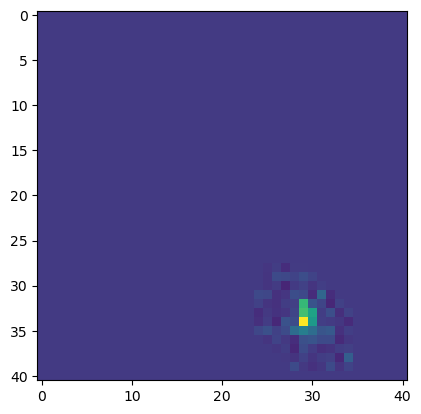

In [46]:

print("Train data 1 first event shape:", np.shape(train_data_1[0]))
testarray = train_data_1[10]
print(testarray)

#plt.set_aspect(1)
plt.imshow(testarray[:,:,0], cmap='viridis',vmin=-5)
plt.show()

In [7]:
##  2023-07-21
##
##  CHECK GENERATOR STEP BY STEP 
##  AND PRINT THE SHAPE OF THE IMAGES
##  TO SEE WHAT IT IS DOING
##
##  NEXT MEETING: WEDNESDAY 2023-08-16

class MyGenerator(keras.utils.Sequence):

    def __init__(self,images_1,images_2,images_3,images_4,labels,batch_size):
        self.batch_size = batch_size
        self.images_1 = images_1
        self.images_2 = images_2
        self.images_3 = images_3
        self.images_4 = images_4
        self.labels = labels
        self.sample_count = len(labels[:])
        self.batch_count = int(self.sample_count/self.batch_size)
        self.current_batch = 0
        self.index = 0

    def __len__(self):
        return self.batch_count


        
    
    def __getitem__(self,index):
        idx_low  = self.current_batch*self.batch_size
        idx_high = (self.current_batch+1)*self.batch_size
        X = np.array([self.images_1[idx_low:idx_high],self.images_2[idx_low:idx_high],self.images_3[idx_low:idx_high],self.images_4[idx_low:idx_high]])
        y = np.array(self.labels[idx_low:idx_high])

        self.current_batch +=1 
        self.data = (X,y)

        return self.data
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= self.sample_count:
            raise StopIteration
        result = self.__getitem__(self.index) 
        self.index += 1
        return result
    
        # Add a new method to plot images and labels for a specific event
    def plot_batch(self, event_nr=100):
        #image_batch = np.zeros((len(self.images_1[event_nr]),1,4))
        print(np.shape(self.images_1))
        print(np.shape(self.images_1[event_nr]))
        image_batch_1 = self.images_1
        image_batch_2 = self.images_2
        image_batch_3 = self.images_3
        image_batch_4 = self.images_4

        #image_batch = np.array([np.array(self.images_1[event_nr]),
        #               np.array(self.images_2[event_nr]),
        #               np.array(self.images_3[event_nr]),
        #               np.array(self.images_4[event_nr])])
        
        label_batch = self.labels
        plot_image_2by2(image_batch_1,image_batch_2,image_batch_3,image_batch_4, labels=label_batch, event_nr=event_nr)

    def __shape__(self):
        print("Shape of self.images1: ",np.shape(self.images_1))
        print("Shape of first event: ",np.shape(self.images_1[0]))

    def reset_counters(self): 
        self.current_batch = 0 

        
    def on_epoch_end(self):
        self.reset_counters()


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

batch_size = 256
train_generator = train_datagen.flow(train_data, train_labels, batch_size=batch_size)
valid_generator = train_datagen.flow(train_data, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_data, batch_size=1)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (194, 4, 41, 41, 1))

Shape of self.images1:  (194, 41, 41, 1)
Shape of first event:  (41, 41, 1)
(194, 41, 41, 1)
(41, 41, 1)
6
(41, 41, 1)
(41, 41, 1)
(41, 41)


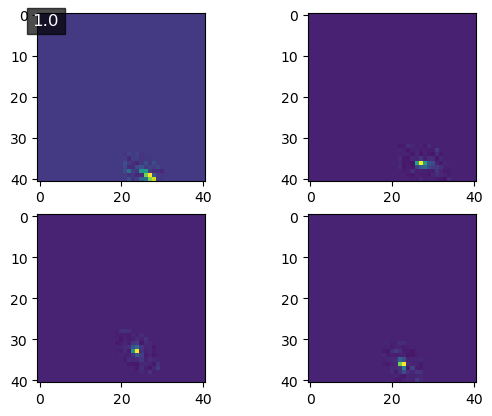

In [75]:
global training_generator
global testing_generator

training_generator = MyGenerator(train_data_1,train_data_2,train_data_3,train_data_4,train_labels,batch_size=64)
testing_generator = MyGenerator(test_data_1,test_data_2,test_data_3,test_data_4,test_labels,batch_size=16)

# Generate data and plot the first batch
batch_index = 6

training_generator.__shape__()
training_generator.plot_batch(batch_index)


In [2]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")

print("Current date and time:", formatted_datetime)

Current date and time: 2023-08-11_10-58


In [13]:
import numpy as np
array = np.empty((500,4,41,41))
array_shape = np.zeros_like(array)
#print(array_shape)
mapped_images = np.zeros_like(array_shape)
random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8
print(random_selection[0:10])
random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8
print(random_selection[0:10])
random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8
print(random_selection[0:10])

[False  True  True  True  True  True False  True  True  True]
[ True  True  True  True  True False  True False  True  True]
[ True  True False  True  True  True  True False  True False]


In [16]:
max_value = 100
length = 10

random_list = np.random.randint(max_value, size=length)
print(random_list)
random_list = np.random.randint(max_value, size=length)
print(random_list)
random_list = np.random.randint(max_value, size=length)
print(random_list)

[ 9 28 86 91 27 57 16 29 58 65]
[81 57  1 73  9 31 23  3 23 49]
[49 14 22 62 21 95 17 26 55 44]
